# Make a custom SED plot
This example downloads the output file from a fit, and makes sed and f limit plots.

## First, using the json model output

In [1]:
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib notebook

In [2]:
mpl.rc('lines', linewidth=3)
mpl.rc('axes', linewidth=1)

In [3]:
s = requests.get('http://drgmk.com/sdb/seds/masters/sdb-v2-155113.93+353926.6/public/'
                 'sdb-v2-155113.93+353926.6-mnest/phoenix_m+modbb_disk_r_.json')
r = json.loads(s.content)

<IPython.core.display.Javascript object>


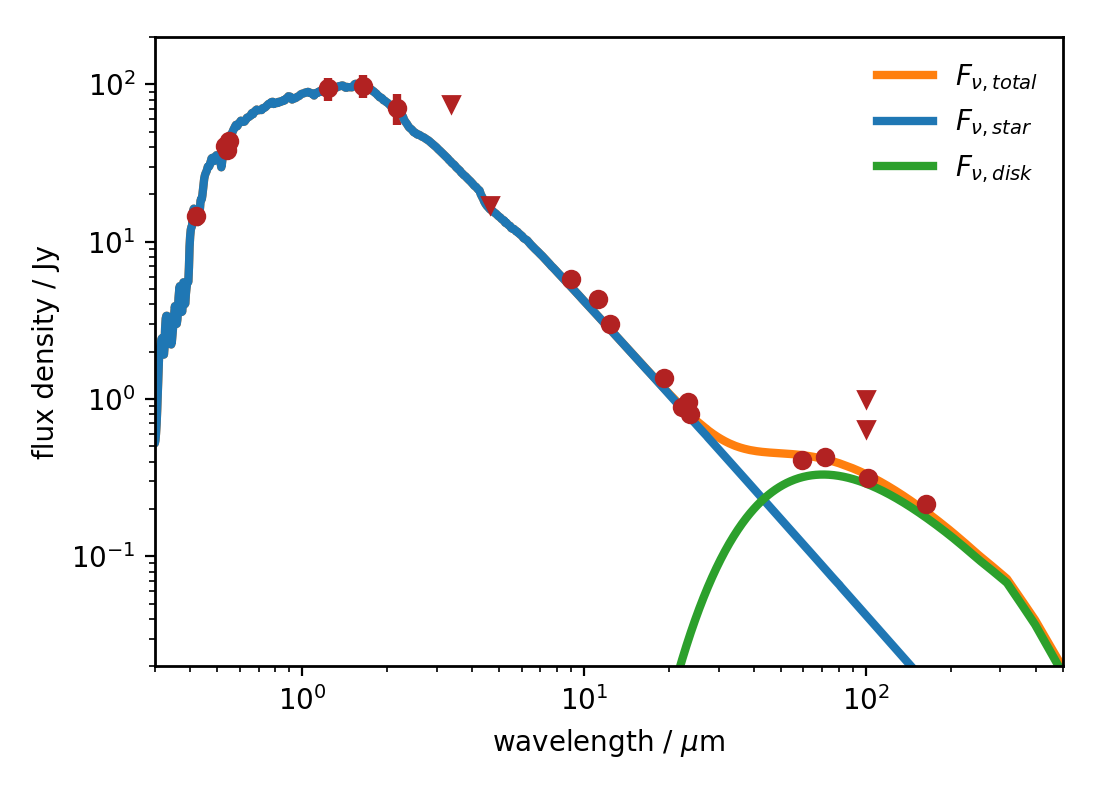

In [4]:
# make the plot
fig,ax = plt.subplots(figsize=(5.5,4))

# stellar and total spectra
ax.loglog(r['star_spec']['wavelength'],
          r['star_spec']['fnujy']+np.interp(r['star_spec']['wavelength'],
                                            r['disk_spec']['wavelength'],
                                            r['disk_spec']['fnujy']),
          label='$F_{\\nu,total}$', color='C1')

ax.loglog(r['star_spec']['wavelength'],r['star_spec']['fnujy'],label='$F_{\\nu,star}$', color='C0')
ax.loglog(r['disk_spec']['wavelength'],r['disk_spec']['fnujy'],label='$F_{\\nu,disk}$', color='C2')

wavelength = np.array(r['phot_wavelength'][0])
filter = np.array(r['phot_band'][0])
fnujy = np.array(r['phot_fnujy'][0])
e_fnujy = np.array(r['phot_e_fnujy'][0])
upperlim = np.array(r['phot_upperlim'][0])
ignore = np.array(r['phot_ignore'][0])

# photometry
ok = np.invert(np.logical_or(upperlim, ignore))
for i,f in enumerate(filter):
    if '_' in f or 'STROM' in f:
        ok[i] = False

ax.errorbar(wavelength[ok], fnujy[ok], yerr=e_fnujy[ok], fmt='o',color='firebrick')
ax.plot(wavelength[upperlim], fnujy[upperlim], 'v', color='firebrick')

# annotation
ax.set_ylim(2e-2,200)
ax.set_xlim(0.3,500)
ax.set_ylabel('flux density / Jy')
ax.set_xlabel('wavelength / $\mu$m')

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('sed_json.pdf')

## Second, using the pickle output (which needs sdf)

In [5]:
import pickle
import sdf

%matplotlib notebook

In [6]:
s = requests.get('http://drgmk.com/sdb/seds/masters/sdb-v2-155113.93+353926.6/public/'
                 'sdb-v2-155113.93+353926.6-mnest/phoenix_m+modbb_disk_r_.pkl')
r = pickle.loads(s.content)
        
# refill these, as they're deleted to save space when the pickle is saved
mod,plmod = sdf.model.get_models(r.obs,r.model_comps)
r.models = mod
r.pl_models = plmod

<IPython.core.display.Javascript object>


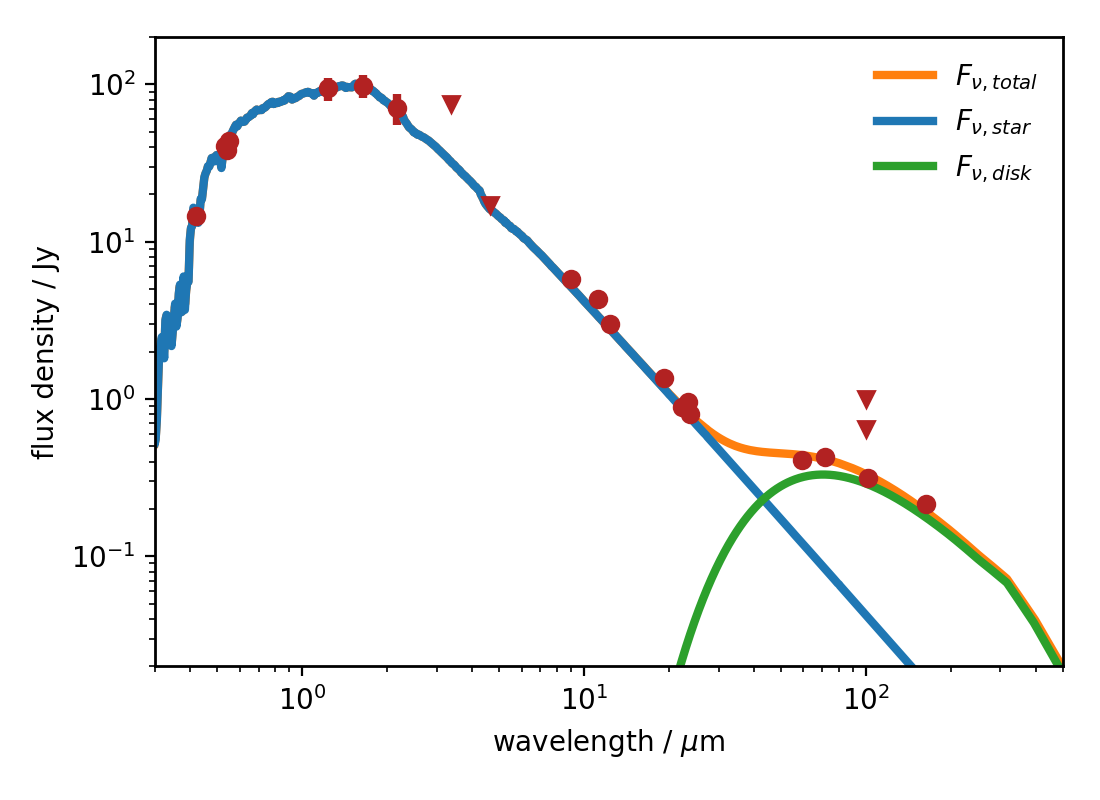

In [7]:
# make the plot
fig,ax = plt.subplots(figsize=(5.5,4))

# stellar and total spectra
ax.plot(r.total_spec.wavelength,r.total_spec.fnujy,label='$F_{\\nu,total}$', color='C1')
ax.loglog(r.comp_spectra[0].wavelength,r.comp_spectra[0].fnujy,label='$F_{\\nu,star}$', color='C0')
ax.loglog(r.comp_spectra[1].wavelength,r.comp_spectra[1].fnujy,label='$F_{\\nu,disk}$', color='C2')

# photometry
for p in r.obs:
    if not isinstance(p,sdf.photometry.Photometry):
        continue

    ok = np.invert(np.logical_or(p.upperlim,p.ignore))
    for i,f in enumerate(p.filters):
        if sdf.filter.iscolour(f):
            ok[i] = False

    ax.errorbar(p.mean_wavelength()[ok],p.fnujy[ok],yerr=p.e_fnujy[ok],
                fmt='o',color='firebrick')
    ax.plot(p.mean_wavelength()[p.upperlim],p.fnujy[p.upperlim],'v',color='firebrick')

# annotation
ax.set_ylim(2e-2,200)
ax.set_xlim(0.3,500)
ax.set_ylabel('flux density / Jy')
ax.set_xlabel('wavelength / $\mu$m')

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('sed_pickle.pdf')

<IPython.core.display.Javascript object>


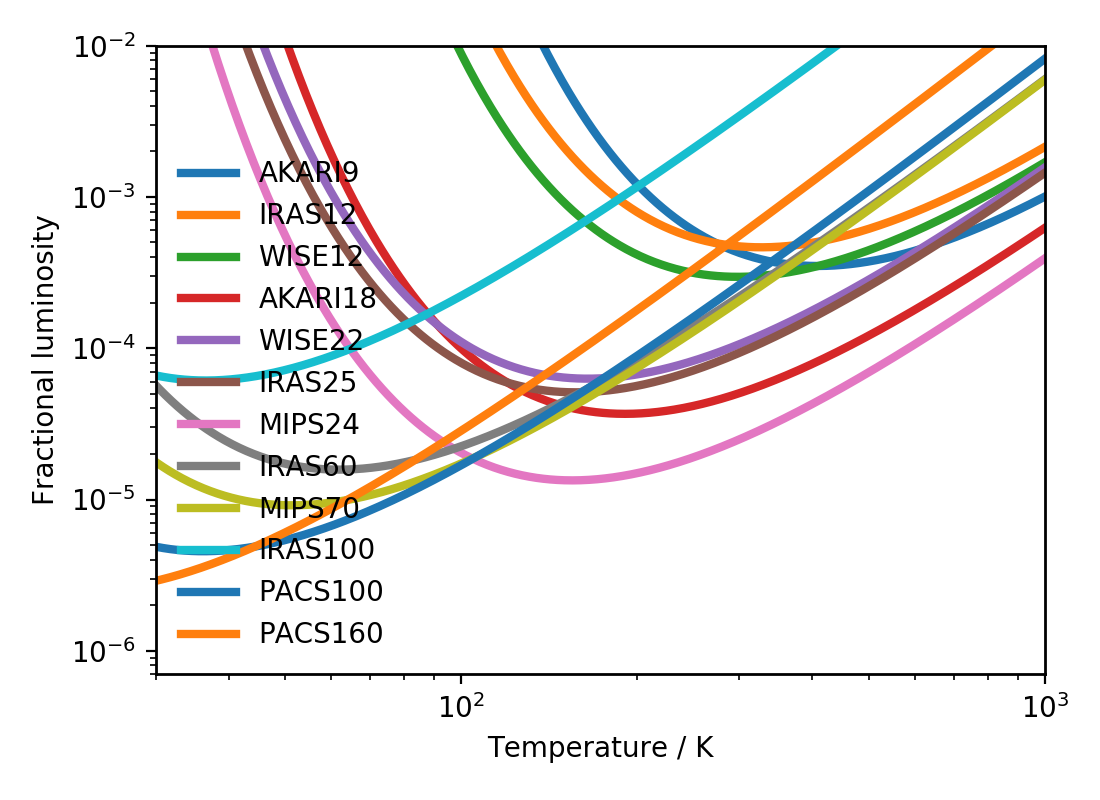

In [8]:
bb = sdf.analytics.BB_Disk()
lim,labels = bb.f_limits_from_result(r)

fig,ax = plt.subplots(figsize=(5.5,4))

for i in range(lim.shape[1]):
    ax.loglog(bb.temperatures,lim[:,i],label=labels[i])
    
ax.set_xlabel('Temperature / K')
ax.set_ylabel('Fractional luminosity')

ax.set_xlim(30,1000)
ax.set_ylim(0.7e-6,1e-2)

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('f_T.pdf')